Probe pixel size: 1.8785484606060606e-07
Model object shape: (400, 400)
Probe shape: (180, 180)
Positions shape: (900, 2)
Object shape: (400, 400)
Probe shape: (180, 180)
Diffraction patterns shape: (900, 180, 180)
Positions shape: (900, 2)


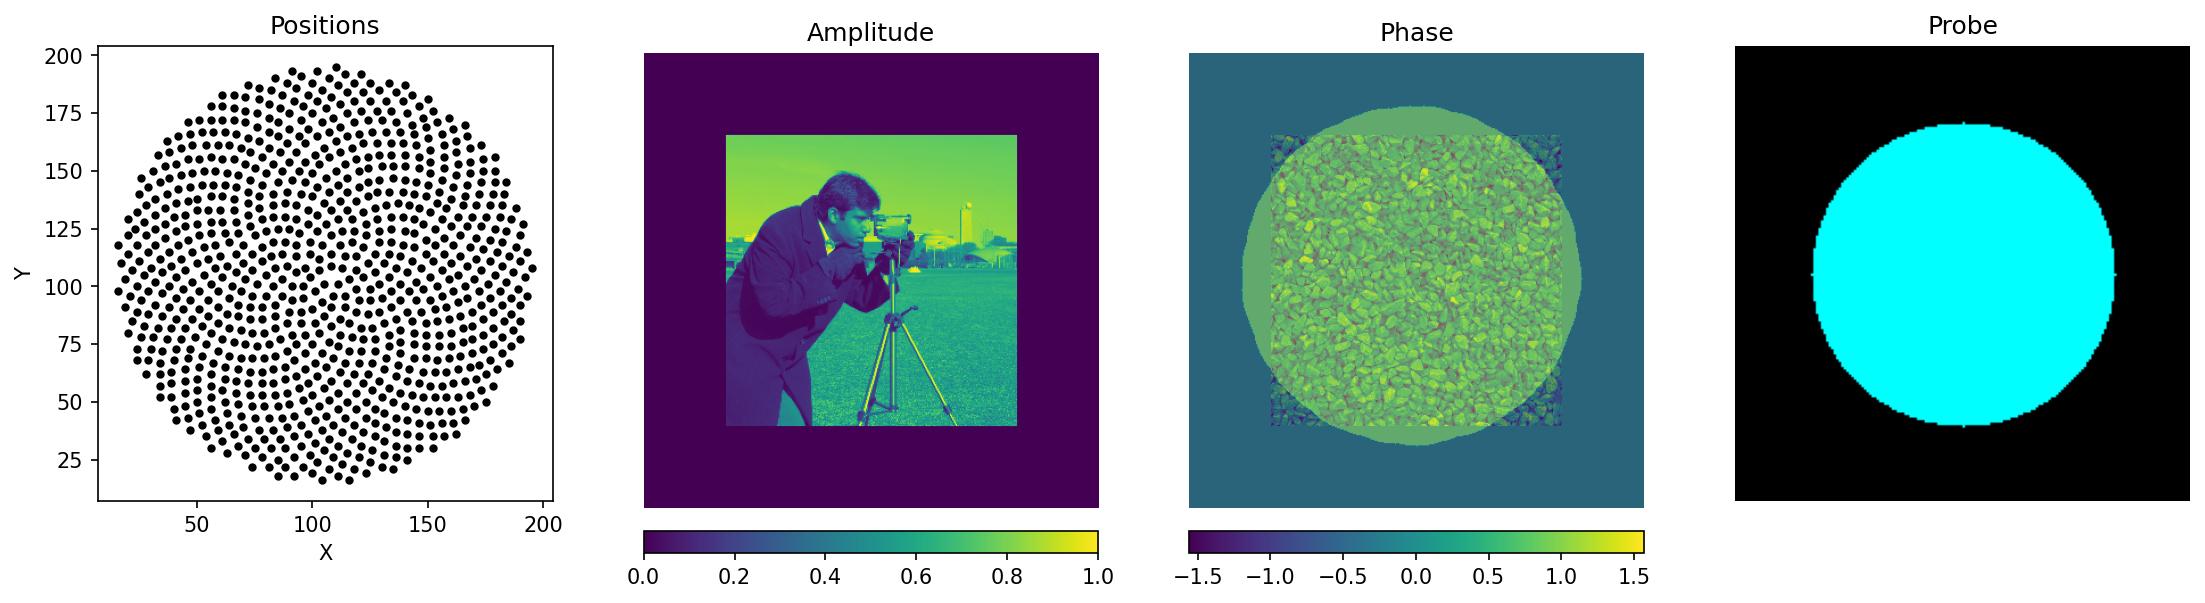

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.ndimage import zoom
import matplotlib.colors

def wavelength_meters_from_energy_keV(E_keV):
    """Calculate the wavelength in meters from energy in keV."""
    hc_keV_Angstrom = 12.39841984
    λ_angstroms = hc_keV_Angstrom / E_keV
    λ_meters = λ_angstroms * 1e-10
    return λ_meters

def create_2d_gaussian(N, M, sigma_x, sigma_y, mu_x=None, mu_y=None):
    """Create a 2D Gaussian distribution."""
    if mu_x is None:
        mu_x = N / 2
    if mu_y is None:
        mu_y = M / 2

    x = np.linspace(0, N - 1, N)
    y = np.linspace(0, M - 1, M)
    x, y = np.meshgrid(x, y)

    gaussian = np.exp(-(((x - mu_x) ** 2) / (2 * sigma_x ** 2) + ((y - mu_y) ** 2) / (2 * sigma_y ** 2)))
    return gaussian

def create_2d_disk(N, M, radius):
    """Create a 2D disk."""
    x = np.linspace(0, N - 1, N)
    y = np.linspace(0, M - 1, M)
    x, y = np.meshgrid(x, y)
    disk = np.where((x - N / 2) ** 2 + (y - M / 2) ** 2 <= radius ** 2, 1, 0)
    return disk

def apply_random_shifts_to_positions(pos_x, pos_y, mu=0, sigma=2, type='gaussian'):
    """Apply random shifts to positions."""
    if type == 'gaussian':
        deltaX = np.random.normal(mu, sigma, pos_x.shape)
        deltaY = np.random.normal(mu, sigma, pos_y.shape)
    elif type == 'random':
        deltaX = np.round(sigma * np.random.rand(*pos_x.shape))
        deltaY = np.round(sigma * np.random.rand(*pos_y.shape))

    new_positions_x = pos_x + deltaX
    new_positions_y = pos_y + deltaY

    new_positions_x -= np.min(new_positions_x)
    new_positions_y -= np.min(new_positions_y)

    return new_positions_x, new_positions_y

def spiral_indices(n_rows, n_cols):
    """Generate indices to traverse a 2D array in spiral order."""
    idx = np.arange(n_rows * n_cols).reshape(n_rows, n_cols)
    spiral = []
    x_min, x_max = 0, n_cols - 1
    y_min, y_max = 0, n_rows - 1

    while x_min <= x_max and y_min <= y_max:
        # Top row
        for x in range(x_min, x_max + 1):
            spiral.append((y_min, x))
        y_min += 1
        # Right column
        for y in range(y_min, y_max + 1):
            spiral.append((y, x_max))
        x_max -= 1
        # Bottom row
        if y_min <= y_max:
            for x in range(x_max, x_min - 1, -1):
                spiral.append((y_max, x))
            y_max -= 1
        # Left column
        if x_min <= x_max:
            for y in range(y_max, y_min - 1, -1):
                spiral.append((y, x_min))
            x_min += 1
    return spiral

def get_positions_array(frame_shape, method='grid', num_points_x=10, num_points_y=10, random_positions=True, plot=True):
    """Generate positions array for ptychography scans."""
    if method == 'grid':
        x_positions = np.linspace(0, frame_shape[1] - 1, num=num_points_x)
        y_positions = np.linspace(0, frame_shape[0] - 1, num=num_points_y)
        pos_x, pos_y = np.meshgrid(x_positions, y_positions)
        if random_positions:
            pos_x, pos_y = apply_random_shifts_to_positions(pos_x, pos_y)
        positions = np.vstack((pos_x.flatten(), pos_y.flatten())).T
    elif method == 'fermat':
        total_points = num_points_x * num_points_y
        max_radius = min(frame_shape[0], frame_shape[1]) / 2  # Maximum radius
        golden_angle = np.pi * (3 - np.sqrt(5))  # Approximately 2.399963
        k = np.arange(1, total_points + 1)
        r = max_radius * np.sqrt(k / total_points)
        theta = k * golden_angle
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        # Center the positions
        x += frame_shape[1] / 2
        y += frame_shape[0] / 2
        positions = np.vstack((x, y)).T
    else:
        raise ValueError("Unknown method: choose 'grid', 'spiral', or 'fermat'.")

    if plot:
        plt.figure(dpi=100)
        plt.plot(positions[:, 0], positions[:, 1], '.', color='black')
        plt.title(f'Positions ({method.capitalize()})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.gca().set_aspect('equal')
        plt.show()

    return positions

def convert_complex_to_RGB(arr):
    """Convert a complex array to an RGB image for visualization."""
    magnitude = np.abs(arr)
    phase = np.angle(arr)
    # Normalize magnitude and phase to [0,1]
    magnitude = magnitude / np.max(magnitude)
    phase = (phase + np.pi) / (2 * np.pi)
    hsv = np.zeros(arr.shape + (3,))
    hsv[..., 0] = phase  # Hue
    hsv[..., 1] = 1.0    # Saturation
    hsv[..., 2] = magnitude  # Value
    rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

def generate_ptychography_dataset(obj, probe, positions, add_position_errors=False, plot=True):
    """Generate synthetic ptychography dataset."""
    if obj.ndim != 2 or probe.ndim != 2:
        raise ValueError("obj and probe must be 2D arrays.")

    probe_size_y, probe_size_x = probe.shape

    if probe_size_y > obj.shape[0] or probe_size_x > obj.shape[1]:
        raise ValueError("Probe must be smaller than the object.")

    print('Model object shape:', obj.shape)
    print('Probe shape:', probe.shape)
    print('Positions shape:', positions.shape)
    
    diff_patterns = []
    probe_story_mask = np.zeros_like(obj, dtype=float)
    for i, position in enumerate(positions):
        px, py = np.round(position).astype(int)
        # Ensure indices are within bounds
        if py + probe_size_y > obj.shape[0] or px + probe_size_x > obj.shape[1] or py < 0 or px < 0:
            continue  # Skip positions that would go out of bounds
        wavefront = obj[py:py + probe_size_y, px:px + probe_size_x] * probe
        probe_story_mask[py:py + probe_size_y, px:px + probe_size_x] += np.abs(probe)
        diffraction = np.abs(np.fft.fftshift(np.fft.fft2(wavefront))) ** 2
        diff_patterns.append(diffraction)

    diff_patterns = np.array(diff_patterns)
    probe_story_mask = np.where(probe_story_mask > 0, 1, 0)

    if plot:
        fig, ax = plt.subplots(1, 4, dpi=150, figsize=(18, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

        # Plot positions
        ax[0].plot(positions[:, 0], positions[:, 1], '.', label='Original', color='black')
        ax[0].set_title('Positions')
        ax[0].set_xlabel('X')
        ax[0].set_ylabel('Y')
        ax[0].set_aspect('equal')

        # Plot amplitude and phase for the object
        ax[1].set_title('Amplitude')
        amp_img = ax[1].imshow(np.abs(obj), cmap='viridis')
        # ax[1].imshow(probe_story_mask, alpha=0.3)
        fig.colorbar(amp_img, ax=ax[1], orientation='horizontal', fraction=0.046, pad=0.04)

        ax[2].set_title('Phase')
        phase_img = ax[2].imshow(np.angle(obj), cmap='viridis')
        ax[2].imshow(probe_story_mask, alpha=0.3)
        fig.colorbar(phase_img, ax=ax[2], orientation='horizontal', fraction=0.046, pad=0.04)

        # Plot amplitude and phase for the probe
        ax[3].set_title('Probe')
        probe_rgb_img = ax[3].imshow(convert_complex_to_RGB(probe))

        ax[1].axis('off')
        ax[2].axis('off')
        ax[3].axis('off')

    return diff_patterns, positions, None, probe_story_mask

def generate_synthetic_ptychography_dataset(N, num_points_x=10, num_points_y=10, positions_method='grid', plot=True):
    """Generate synthetic ptychography dataset with options to specify positions method."""
    # Define parameters
    energy = 10  # keV
    distance = 15  # meters
    wavelength = wavelength_meters_from_energy_keV(energy)  # meters
    detector_pixel_size = 55e-6

    # Adjust other parameters according to N
    probe_pixel_size = wavelength * distance / (N * detector_pixel_size)
    print('Probe pixel size:', probe_pixel_size)

    # Create probe
    sigma = N / 6  # Equivalent to sigma = 30 when N=180
    disk_radius = N / 3  # Equivalent to disk_radius = 60 when N=180
    probe = create_2d_gaussian(N, N, sigma, sigma)
    disk = create_2d_disk(N, N, disk_radius)
    probe = probe * disk
    probe[probe > 0] = 1
    probe = probe / np.max(probe)
    probe_phase = np.zeros_like(probe)
    probe = probe * np.exp(1j * probe_phase)

    # Create object
    image1 = getattr(data, 'camera')()
    image2 = getattr(data, 'gravel')()

    # Downsample images if needed
    camera = image1[0::2, 0::2]
    gravel = image2[0::2, 0::2]

    # Scale images
    image_size = camera.shape[0]
    zoom_factor = N / 180  # Equivalent to zoom_factor = 1 when N=180
    camera = zoom(camera, zoom_factor, order=3)
    gravel = zoom(gravel, zoom_factor, order=3)

    # Pad images to target size
    target_size = int(N * (400 / 180))  # Equivalent to target_size = 400 when N=180
    pad_y = (target_size - camera.shape[0]) // 2
    pad_x = (target_size - camera.shape[1]) // 2
    camera = np.pad(camera, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)
    gravel = np.pad(gravel, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

    camera = camera / camera.max()
    gravel_normalized = (gravel - np.min(gravel)) * (2 * np.pi) / (np.max(gravel) - np.min(gravel)) - np.pi
    gravel_normalized = gravel_normalized / 2
    obj = camera * np.exp(1j * gravel_normalized)

    # Generate positions using the specified method
    positions = np.round(get_positions_array(
        probe.shape, method=positions_method, num_points_x=num_points_x, num_points_y=num_points_y,
        random_positions=(positions_method == 'grid'), plot=False))
    positions += int(N / 12)  # Adjust positions

    # Adjust positions to be within object bounds
    max_y, max_x = obj.shape
    valid_indices = []
    for i, (px, py) in enumerate(positions):
        if py + probe.shape[0] <= max_y and px + probe.shape[1] <= max_x and py >= 0 and px >= 0:
            valid_indices.append(i)
    positions = positions[valid_indices]

    # Generate dataset
    diff_patterns, positions, positions_errors, probe_story_mask = generate_ptychography_dataset(
        obj, probe, positions, plot=plot)

    metadata = {
        'energy': energy,
        'distance': distance,
        'wavelength': wavelength,
        'probe_pixel_size': probe_pixel_size,
        'detector_pixel_size': detector_pixel_size,
        'probesize': probe.shape,
        'objectsize': obj.shape
    }

    # Return the outputs
    return obj, probe, diff_patterns, positions, metadata

# Example usage:
N = 180  # Specify the object size
positions_method = 'fermat'  # Choose 'grid' or 'fermat'
num_points_x = 30  # Number of points in X direction
num_points_y = 30  # Number of points in Y direction
obj, probe, diff_patterns, positions, metadata = generate_synthetic_ptychography_dataset(
    N=N, num_points_x=num_points_x, num_points_y=num_points_y, positions_method=positions_method)

print("Object shape:", obj.shape)
print("Probe shape:", probe.shape)
print("Diffraction patterns shape:", diff_patterns.shape)
print("Positions shape:", positions.shape)

# Optionally save data
# path = "/your/path/here/"
# import os, json
# with open(os.path.join(path, 'metadata.json'), 'w') as f:
#     json.dump(metadata, f, indent=4)

# np.save(os.path.join(path, 'diff_patterns.npy'), diff_patterns)  # save diffraction patterns
# np.save(os.path.join(path, 'positions.npy'), positions)  # save positions
# np.save(os.path.join(path, 'object.npy'), obj)
# np.save(os.path.join(path, 'probe.npy'), probe)
